In [ ]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import models

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

In [24]:
train_df = pd.read_csv("../data/fakeddit_train.tsv", sep = "\t")
val_df = pd.read_csv("../data/fakeddit_val.tsv", sep = "\t")
test_df = pd.read_csv("../data/fakeddit_test.tsv", sep = "\t")
#images in images folder with name: f"{id}.jpg"


print(train_df.head())

print(train_df.columns)
print(train_df.head())


In [25]:
# tokenize titles for BERT
def tokenize_titles(df, column_name='clean_title', max_length=256, device='cpu'):

    titles = df[column_name].astype(str).tolist()

    # use BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_encoded = bert_tokenizer(
        titles,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    return df, bert_encoded

# tokenize for train, validation and test sets
train_df, train_bert_tokens = tokenize_titles(train_df)
val_df, val_bert_tokens = tokenize_titles(val_df)
test_df, test_bert_tokens = tokenize_titles(test_df)

Text & Image pytorch dataset
Text only pytorch dataset
Image only pytorch dataset

In [26]:
class NewsMultimodalDataset(Dataset):
    """Return dict: input_ids, attention_mask, image, label"""
    def __init__(self, df, tokenizer, transform, img_dir="../data/images", max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        # ensure label is Python int
        label = int(row['3_way_label'])

        # Text tokenization
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        # Image loading
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            # helpful debug: raise an error early
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)  # tensor

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        label = int(row['3_way_label'])
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform, img_dir="../data/images"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['3_way_label'])
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


Dataloader

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# text dataset to dataloader
train_text = TextOnlyDataset(train_df, tokenizer)
val_text = TextOnlyDataset(val_df, tokenizer)
test_text = TextOnlyDataset(test_df, tokenizer)

train_text_loader = DataLoader(train_text, batch_size=16, shuffle=True)
val_text_loader = DataLoader(val_text, batch_size=16, shuffle=True)
test_text_loader = DataLoader(test_text, batch_size=16, shuffle=True)

# image dataset to dataloader
train_image = ImageOnlyDataset(train_df, transform)
val_image = ImageOnlyDataset(val_df, transform)
test_image = ImageOnlyDataset(test_df, transform)

train_image_loader = DataLoader(train_image, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_image, batch_size=16, shuffle=True)
test_image_loader = DataLoader(test_image, batch_size=16, shuffle=True)

# text and image dataset to loade
train_ds = NewsMultimodalDataset(train_df, tokenizer, transform)
val_ds = NewsMultimodalDataset(val_df, tokenizer, transform)
test_ds = NewsMultimodalDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

BERT + RESNET & Fusion
late/feature fusion: Extract separate embeddings from each modality, then concatenate them before classification.

BERT model

In [29]:
class TextClassifier(nn.Module):
    def __init__(self, text_model_name='bert-base-uncased', num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = out.pooler_output  # [CLS]
        logits = self.classifier(pooled)
        return logits

ResNet model

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        # Replace final fc
        self.backbone.fc = nn.Linear(in_feat, num_labels)
        for name, p in self.backbone.named_parameters():
            p.requires_grad = False
        # classifier weights trainable
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion of BERT and ResNet

In [ ]:
class BertResNetLateFusion(nn.Module):
    def __init__(self, text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, freeze_encoders=True):
        super().__init__()

        # Load pretrained text encoder
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim
        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # load only bert weights (not fc)
                self.bert.load_state_dict({k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained image encoder
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)  # reduce to 512-dim
        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                self.resnet.load_state_dict({k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Optionally freeze encoders
        if freeze_encoders:
            for param in self.bert.parameters():
                param.requires_grad = False
            for param in self.resnet.parameters():
                param.requires_grad = False

        # Fusion
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output) 

        # Image embedding
        img_emb = self.img_fc(self.resnet(image)) 

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits


import torch
import torch.nn as nn
from transformers import BertModel
from torchvision.models import resnet50, ResNet50_Weights

class BertResNetFusion(nn.Module):
    def __init__(self, text_model_name='bert-base-uncased', num_classes=3):
        super().__init__()
        
        # Text encoder
        self.bert = BertModel.from_pretrained(text_model_name)
        
        # Freeze encoders (optional)
        for param in self.bert.parameters():
            param.requires_grad = True

        # Image encoder
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = True
        self.resnet.fc = nn.Identity()  # remove classifier
        
        # Fusion head
        self.fc = nn.Sequential(
            nn.Linear(768 + 2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_out.pooler_output  # [batch, 768]

        # Image features
        img_feat = self.resnet(image)  # [batch, 2048]

        # Fusion
        combined = torch.cat((text_feat, img_feat), dim=1)
        logits = self.fc(combined)
        return logits


train model: prob here preds n truth part i think

Train BERT text model - 2e-5 overfits

In [32]:
def evaluate_text_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1


In [ ]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")
        
        vloss, vacc, vf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model


In [38]:
text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [23:14<00:00,  1.35it/s]


Epoch 1 | Train Loss: 0.5040, Accuracy: 0.7780, F1: 0.7767
Validation Loss: 0.4180, Accuracy: 0.8237, F1: 0.8232


Epoch 2: 100%|██████████| 1886/1886 [25:04<00:00,  1.25it/s]


Epoch 2 | Train Loss: 0.3110, Accuracy: 0.8749, F1: 0.8747
Validation Loss: 0.4389, Accuracy: 0.8253, F1: 0.8253


Epoch 3: 100%|██████████| 1886/1886 [24:47<00:00,  1.27it/s]


Epoch 3 | Train Loss: 0.1676, Accuracy: 0.9383, F1: 0.9382
Validation Loss: 0.4936, Accuracy: 0.8234, F1: 0.8228


Epoch 4: 100%|██████████| 1886/1886 [24:21<00:00,  1.29it/s]


Epoch 4 | Train Loss: 0.0867, Accuracy: 0.9694, F1: 0.9694
Validation Loss: 0.5730, Accuracy: 0.8258, F1: 0.8249


Epoch 5: 100%|██████████| 1886/1886 [25:35<00:00,  1.23it/s]


Epoch 5 | Train Loss: 0.0564, Accuracy: 0.9806, F1: 0.9806
Validation Loss: 0.7227, Accuracy: 0.8221, F1: 0.8211


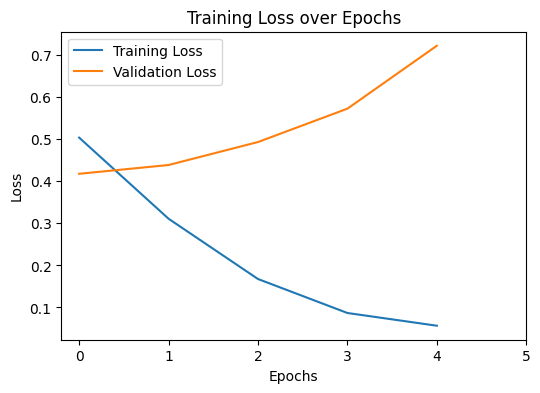

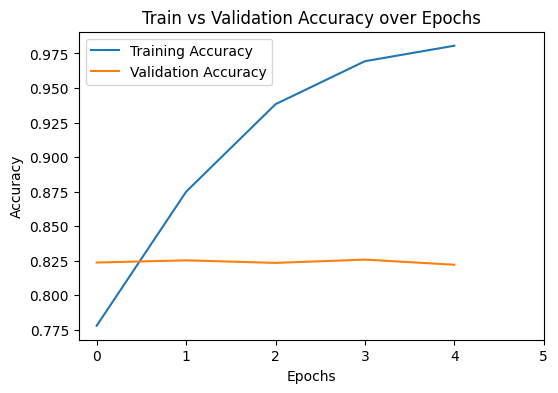

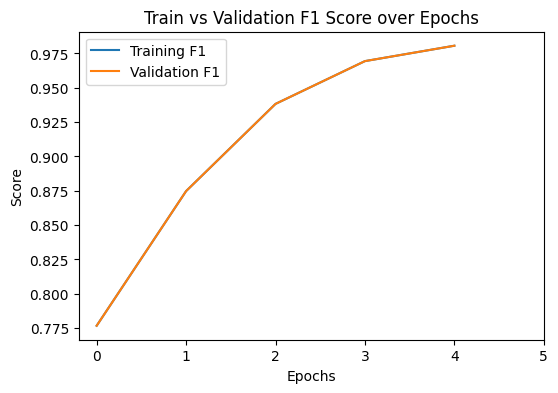

In [39]:
# Plots
import matplotlib.pyplot as plt

# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()


Text only BERT model performance on test set

In [40]:
test_loss, test_acc, test_f1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.7547, Accuracy: 0.8142, F1: 0.8126


Save BERT model for fusion later

In [41]:
torch.save(text_model.state_dict(), "bert_text_only.pt")

Train Image only ResNet model

In [42]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [52]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model

In [53]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [2:21:57<00:00,  4.52s/it]  


Epoch 1 | Train Loss: 0.6495, Acc: 0.6811, F1: 0.6703
Validation Loss: 0.5947, Accuracy: 0.7174, F1: 0.7086


Epoch 2: 100%|██████████| 1886/1886 [2:11:37<00:00,  4.19s/it]  


Epoch 2 | Train Loss: 0.5583, Acc: 0.7337, F1: 0.7277
Validation Loss: 0.6098, Accuracy: 0.7192, F1: 0.7148


Epoch 3: 100%|██████████| 1886/1886 [1:50:42<00:00,  3.52s/it]


Epoch 3 | Train Loss: 0.4801, Acc: 0.7787, F1: 0.7757
Validation Loss: 0.6159, Accuracy: 0.7195, F1: 0.7130


Epoch 4: 100%|██████████| 1886/1886 [1:48:38<00:00,  3.46s/it]


Epoch 4 | Train Loss: 0.3978, Acc: 0.8251, F1: 0.8239
Validation Loss: 0.6742, Accuracy: 0.7097, F1: 0.7083


Epoch 5: 100%|██████████| 1886/1886 [1:48:11<00:00,  3.44s/it]


Epoch 5 | Train Loss: 0.3104, Acc: 0.8686, F1: 0.8681
Validation Loss: 0.7129, Accuracy: 0.7036, F1: 0.7026


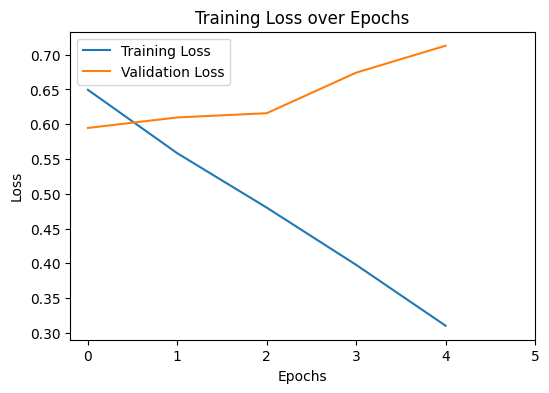

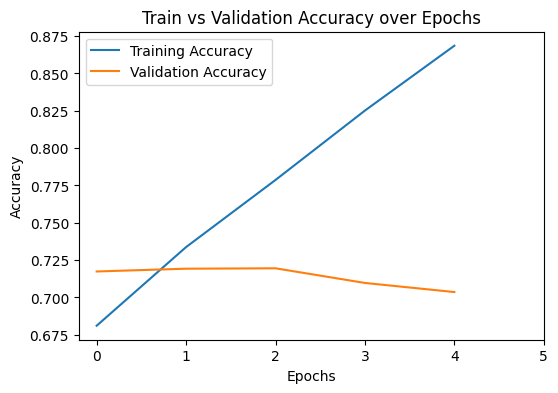

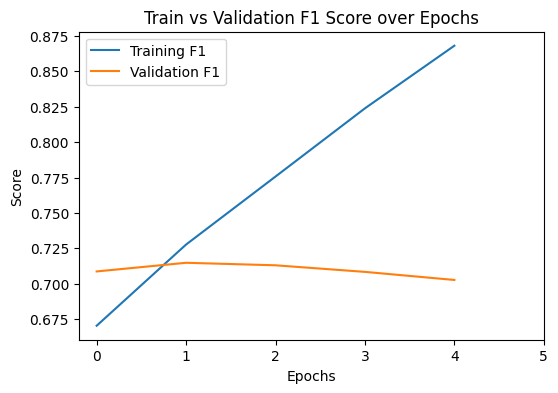

In [54]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

Image only ResNet performance on test data

In [55]:
tloss, tacc, tf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6959, Accuracy: 0.6943, F1: 0.6934


save image only ResNet model

In [56]:
torch.save(image_model.state_dict(), "resnet_image_only.pt")

Train BERT and ResNet Fusion model

In [57]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [58]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [61]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:36:46<00:00,  3.08s/it]


Epoch 1 | Train Loss: 0.0491, Acc: 0.9855, F1: 0.9855
Validation Loss: 0.8664, Accuracy: 0.8242, F1: 0.8238
Current α: 0.538


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:46:55<00:00,  3.40s/it]


Epoch 2 | Train Loss: 0.0382, Acc: 0.9876, F1: 0.9876
Validation Loss: 0.9010, Accuracy: 0.8224, F1: 0.8229
Current α: 0.559


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:50:38<00:00,  3.52s/it]


Epoch 3 | Train Loss: 0.0379, Acc: 0.9883, F1: 0.9883
Validation Loss: 0.9561, Accuracy: 0.8261, F1: 0.8251
Current α: 0.573


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:46:41<00:00,  3.39s/it]


Epoch 4 | Train Loss: 0.0364, Acc: 0.9894, F1: 0.9894
Validation Loss: 0.7946, Accuracy: 0.8271, F1: 0.8263
Current α: 0.585


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:31:52<00:00,  2.92s/it]


Epoch 5 | Train Loss: 0.0363, Acc: 0.9879, F1: 0.9879
Validation Loss: 0.9085, Accuracy: 0.8253, F1: 0.8247
Current α: 0.596


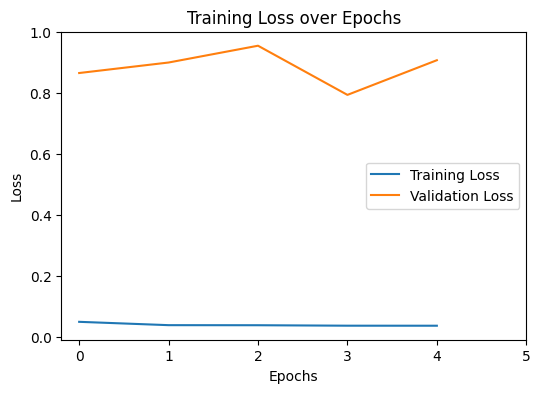

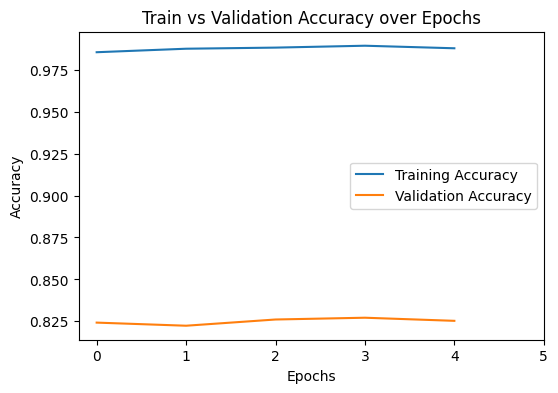

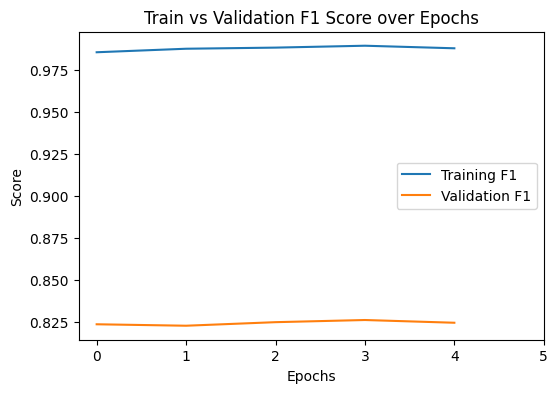

In [62]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

BERT-ResNet fusion model perfromance on test data

In [63]:
tloss, tacc, tf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.9536, Accuracy: 0.8168, F1: 0.8158


Save BERT-ResNet fusion model

In [ ]:
torch.save(fusion_model.state_dict(), "bert_resnet_fusion.pt")